In [1]:
pack <- c("tidyverse", "plyr", "dplyr", "np", "FNN", "modelr", "rpart", "doParallel", "sandwich",
          "grf", "Matching", "boot", "ggplot2")
invisible(suppressMessages(suppressWarnings(lapply(pack, require, character.only = TRUE))))

In [33]:
help_fun <- c("create_output_table.R", "create_output_table_JASA.R", "sim.R", "naive_ate.R", "psw_ate_boot.R", "ols_ate.R",
       "knn_ate.R", "rf_ate.R", "MSE.R", "knn_cate.R",
       "ols_cate.R", "rf_cate.R", "rf_cate_JASA.R",
       "ols_cate_JASA.R", "simAW.R", "plot_data.R")
invisible(lapply(help_fun, source))

$\newcommand{\E}{{\rm I\kern-.3em E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\newcommand{\Covh}{\widehat{\Cov}}$
$\newcommand{\Varh}{\widehat{\Var}}$
$\newcommand{\betah}{\widehat{\beta}}$
$\newcommand{\Eh}{\widehat{\E}}$
$\newcommand{\YO}{Y(0)}$
$\newcommand{\YI}{Y(1)}$
$\newcommand{\indep}{\perp \!\!\! \perp}$
$\newcommand{\atehat}{\widehat{\text{ATE}}}$


# 1 Assumptions + Estimation strategies

Suppose we have random sample (i.i.d.) of the reference population, each containing a feature vector $X_i$, a treatment indicator $D_i$ and an outcome $Y_i$. In short: $\left\{(Y_i,X_i,D_i)\right\}_{i=1}^{n}$.
Generally, we will either assume unconfoundedness (ignorability) or purely random treatment assignment in our DGPs. More formally, random treatment assignment amounts to 
<br>
&ensp;
\begin{equation}
(\YI,\YO)\enspace\indep\enspace D.\label{eq:rt}
\end{equation}
<br>
&ensp;
In situations usually analyzed within the social sciences, this assumption turns out to be too restrictive (ref.). Therefore, as we've seen throughout the course, many methods were developed under the assumption of unconfoundedness:
<br>
&ensp;
\begin{equation}
(\YI,\YO)\enspace\indep\enspace D\enspace \lvert\enspace X.\label{eq:uf}
\end{equation}
<br>
&ensp;
This is also used by [@wager2018estimation] to develop the theory of causal trees/forests.\newline
Within the simulation study we'll also try to stress the consequences for estimation when switching from (\ref{eq:rt}) to (\ref{eq:uf}). 


## 1.1 Heterogeneous Treatment Effects
To develop an intuition for the importance of heterogeneity in treatment effects, we define the Average Treatment Effect (ATE) and the Conditional Average Treatment Effect (CATE) as follows.
<br>
&ensp;
\begin{align}
\delta&\equiv \E(\YI-\YO)\label{eq:ate}\\[10pt]
\delta(x)&\equiv\E(\YI-\YO\vert X=x)\label{eq:cate}\\[10pt]
\end{align}
<br>
&ensp;
These definitions are conceptually different: While the CATE is a real-valued function mapping a realization of the random variable $X$ to a real number, the ATE is a real number. Thus, by definition, the CATE allows to have *distinct* treatment effects for different realizations of $X$. By the law of iterated expectation we have the following relationship between \ref{eq:ate} and \ref{eq:cate}:


\begin{equation}
\E\left(\delta(X)\right)=\delta \label{eq:cateate}
\end{equation}

<br>
&ensp;
Thus, the ATE is a summary statistic of the CATE. Example for illustration + ref.  


When it comes to estimation of both quantities, we have to make sure they're identified in the first place. 
While \ref{eq:uf} is sufficient to identify the ATE \ref{eq:ate}, we need an additional assumption for the CATE \ref{eq:cate}. This is because estimating the CATE requires estimation of a function at _every_ possible point in the support of $X$. Since the function of interest involves both units in treatment and control, we have to assume that we observe both treated and control units at every possible $X=x$. In other words, we assume overlap.

For almost every $x \in \text{supp} X$, 
\begin{equation}
\eta < \text{Pr}(D=1 | X=x)< 1-\eta\enspace\text{for some}\enspace \eta>0 \label{eq:overlap}
\end{equation}
<br>
I will maintain this assumption throughout


## 1.2 Structural representation

For the first part of the simulations, we can postulate the following structural equations.


\begin{align*}
X&= f_{X}(u_1),\\
D&= f_{D}(X),\\
Y&= f_{Y}(X, D, \varepsilon)\\
\end{align*}
The corresponding graph looks as follows.



<img src="Causal_graphs.png" height=300 width=300 />

Note that we could have omitted $\varepsilon$ from the DAG-representation because I'll assume it to be independent of all the other variables throughout (p.88, textbook).
The DAG-representation rightly suggests that identification is rather easy here: blocking the back-door path $D \leftarrow X \rightarrow Y$ is sufficient and can be achieved by controllig for the observable $X$.

## 1.3 Estimation Strategies

### 1.3.1 ATE

In every setting, ATE-estimates will be obtained from five different estimators.

1.) **Naive estimator**
$$\begin{equation}
\widehat{\text{ATE}}_{\text{Naive}} = \bar{Y}_1 - \bar{Y}_{0} =\frac{1}{n_1} \sum_{i: D_i =1}^{} Y_i + \frac{1}{n_0}\sum_{i: D_i = 0}^{} Y_i \label{eq:naive}
\end{equation}$$

2.) **OLS**
<br>
Depending on the option you choose in the function, different OLS-estimates can be obtained:
* `method_ols = "D_only"` estimates $$\begin{equation} Y_i = \alpha + \delta\cdot D_i +\varepsilon_{i,1} \label{eq:donly}\end{equation}$$
* `method_ols = "full"` estimates $$\begin{equation}Y_i = \alpha + \delta\cdot D_i+ X_i\cdot\beta +\gamma\cdot D_i\cdot(X_i-\bar{X}) +\varepsilon_{i,2}\label{eq:full}\end{equation}$$
Thus
$$\begin{equation}
\widehat{\text{ATE}}_{\text{OLS}} = \widehat{\delta}_{\text{OLS}}
\end{equation}$$
<br>
Note that in the former case, the OLS estimate is numerically equivalent to the estimate obtained from the Naive estimator (\ref{eq:naive}).


3.) **Propensity Score Weighting (PSW) estimator** <br>
Let $\widehat{e}(X_i) \equiv \widehat{\text{Pr}}(D_i = 1|X_i)$ the estimated propensity score. Then,
<br>
<br>
$$\begin{equation}
\widehat{\text{ATE}}_{\text{PSW}} = \frac{\sum_{i=1}^{n} \frac{D_i Y_i}{\widehat{e}(X_i)}}{\sum_{i=1}^{n} \frac{D_i}{\widehat{e}(X_i)}} - \frac{\sum_{i=1}^{n} \frac{(1-D_i ) Y_i}{1-\widehat{e}(X_i)}}{\sum_{i=1}^{n} \frac{1- D_i}{1-\widehat{e}(X_i)}}
\end{equation}$$
<br>
I've tested several estimators for the propensity score, among them parametric models such as logit and probit but also semi- and nonparametric kernel erstimators. Since throughout the settings probit and logit give similar results and the remaining methods are too slow, only logit can be used in the function below. 

4.) **k-Nearest-Neighbor Matching**
<br>
As we've seen in the course, matching estimators impute the counterfactual outcomes. More specifically,
<br>
<br>
$$\widehat{Y_i}(0)=\begin{cases}
 Y_i, &\text{if}\enspace D_i = 0 \\
\frac{1}{K} \sum_{j\in \mathcal{J}_{K}(i)}^{} Y_j, &\text{if}\enspace D_i=1
\end{cases}$$
<br>
where $\mathcal{J}_{K}(i) = \left\{j_1 (i), j_2 (i),\ldots,j_K (i)\right\}$.
<br>
$j_k (i)$ is the index of the unit which is the $k$-th closest to unit $i$ in terms of covariate distance and has opposite treatment status.
<br>
Similarly,
<br>
$$\widehat{Y_i}(1)=\begin{cases}
\frac{1}{K} \sum_{j\in \mathcal{J}_{K}(i)}^{} Y_j , &\text{if}\enspace D_i = 0 \\
Y_i, &\text{if}\enspace D_i=1
\end{cases}$$
<br> This setup naturally leads to an averaging estimator of the ATE:
<br>
$$\begin{equation}
\widehat{\text{ATE}}_{\text{kNN}} = \frac{1}{n}\sum_{i=1}^{n}\left(\widehat{Y_i}(1)-\widehat{Y_i}(0)\right)\end{equation}$$

5.) **Causal Forests**
<br>
For a more detailed exposition of the ideas behind using trees for the estimation of treatment effects, please refer to Tim's notebook. The gist of the argument is as follows.
<br>
Define an index set
<br>
$$\mathcal{J}(x, d, \Pi, S) := \{i \mid X_i \in \ell(x; \Pi) \text{ and } D_i = d \text{ and } (Y_i, X_i) \in S \} \,,$$
<br>
 Given we have found a reasonable partition, say $\Pi$, we approximate $\tau$ by 
<br>
<br>
$$\hat{\tau}(x; S, \Pi) = \frac{1}{\left|\mathcal{J}(x, 1, \Pi, S)\right|} \sum_{j \in \mathcal{J}(x, 1, \Pi, S)} Y_j - \frac{1}{\left|\mathcal{J}(x, 0, \Pi, S)\right|} \sum_{j \in \mathcal{J}(x, 0, \Pi, S)} Y_j \,,$$
<br>
<br>
Obviously, the procedure aims at estimating heterogeneous treatment effects: we will obtain such an estimate for all $x$ in the support of $X$.
<br>
Instead of growing a single tree, however, the procedure to be used grows an ensemble of $B$ such trees, where each tree yields an estimate for every point in the support of $X$, $\widehat{\tau}_b (x)$. The forest then outputs the average 
<br>
$$\begin{equation}
\widehat{\text{CATE}}_{\text{RF}}(x) = \frac{1}{B}\sum_{b=1}^{B} \widehat{\tau}_b (x) \label{eq:caterf}
\end{equation}
$$
<br>
Using the relation between the CATE and the ATE in (\ref{eq:cateate}), we construct an estimator for the ATE as follows. 
<br>
$$
\begin{align}
\widehat{\text{ATE}}_{\text{RF}} &= \frac{1}{n}\sum_{i=1}^{n}\left(\widehat{\text{CATE}}_{\text{RF}}(X_i)\right)\\
&= \frac{1}{n}\sum_{i=1}^{n}\left(\frac{1}{B}\sum_{b=1}^{B} \widehat{\tau}_b (X_i )\right) 
\end{align}
$$

### 1.3.2 CATE

For estimation of CATE, we'll restrict attention the three of the above methods. In contrast to ATE-estimation, methods for CATE-estimation will also be tested on a setup with higher-dimensional $X$.

1.) **OLS**
<br>
OLS estimates 
<br>
$$\begin{equation}
Y_i = \alpha + \delta\cdot D_i + \textbf{X}_{i} ^\intercal \beta  + D_i\cdot\left(\textbf{X}_i -\bar{\textbf{X}}\right)^\intercal\gamma + \epsilon_i \label{eq:olscate}
\end{equation}$$
<br>
How do we get to heterogeneous treatment effects from here? Recall that for an estimate of the ATE we would just extract $\widehat{\delta}_{\text{OLS}}$, which is not a function of $x$ and therefore does not permit any statement about heterogeneity in treatment effects. The idea is based on the following observation. If we assume that the conditional expectation function is linear as we specified it, then
<br>
<br>
$$
\begin{align*}
\E(Y_i | \textbf{X}_{i} , D_i) &= \alpha + \delta\cdot D_i + \textbf{X}_{i} ^\intercal \beta  + D_i\cdot
\left(\textbf{X}_i -\bar{\textbf{X}}\right)^\intercal\gamma\\
\\
\E(Y_i (0) | \textbf{X}_{i} ) &= \alpha + \textbf{X}_{i} ^\intercal \beta\\
\E(Y_i (1) | \textbf{X}_{i} ) &= \alpha + \delta\cdot D_i + \textbf{X}_{i} ^\intercal \beta  + D_i\cdot\left(\textbf{X}_i -\bar{\textbf{X}}\right)^\intercal\gamma\\
\\
\E(Y_i (1) - Y_i(0) | \textbf{X}_{i} ) &= \delta + \left(\textbf{X}_i -\bar{\textbf{X}}\right)^\intercal\gamma
\end{align*}
$$
<br>
Thus, estimating (\ref{eq:olscate}) by OLS allows us to compute
<br>
<br>
$$
\begin{equation*}
\widehat{\text{CATE}}_{\text{OLS}}(\textbf{x}) = \widehat{\E}(Y_i (1) - Y_i(0) | \textbf{X}_{i} = \textbf{x}) = \widehat{\delta}_{\text{OLS}} + \left(\textbf{x} -\bar{\textbf{x}}\right)^\intercal\widehat{\gamma}_{\text{OLS}}
\end{equation*}
$$
<br>
Thus we're essentially approximating the true CATE by a linear function. Whether or not that is a decent approximation is entirely determined by the underlying DGP.


2.) **k-Nearest-Neighbor Matching**
<br>
<br>
$$
\begin{equation}
\widehat{\text{CATE}}_{\text{kNN}}(\textbf{x}) = \frac{1}{K}\sum_{j\in \mathcal{J}_{K,1}(\textbf{x})} Y_j - \frac{1}{K}\sum_{j\in \mathcal{J}_{K,0}(\textbf{x})} Y_j  
\end{equation}
$$
<br>
$\mathcal{J}_{K,d}(\textbf{x})$ denotes the set of indices of the $K$ closest units to support point $\textbf{x}$ in terms of covariate values who have treatment status $D =d$. 
<br>
If $d = \text{dim}(\textbf{X}_i) > 1$, then _"close in terms of covariate values"_ means small Euclidean distance $\left\| \textbf{X}_i - \textbf{x}\right\|$

3.) **Causal Forests**
<br>
see (\ref{eq:caterf})

# 2 Simulation: One-dimensional $X$

## 2.1 DGP

For nearly the whole first part of the simulations, I'll stick to models that are linear in parameters when it comes to generating the potential outcomes. In addition, the first part will exclusively consider the case in which the feature vector $X$ is of dimension $1$. The models under consideration will be special cases of the following DGP:
<br>
&ensp;
\begin{align}
Y(0)&=\gamma_0 + \gamma_1\cdot g(X)+ \gamma_2\cdot h(\gamma_3 X) +\varepsilon_0 \\
Y(1)&=\phi_0 + \phi_1\cdot f(X)+ \phi_2\cdot c(\phi_3 X)+\varepsilon_1 ,
\end{align}
<br>
&ensp;
where

* $\varepsilon_j \stackrel{\text{i.i.d}}{\sim} \mathcal{N}(0,1),\enspace j=0,1,\quad X \stackrel{\text{i.i.d}}{\sim} U[0,1]$
<br>
&ensp;
* $g(\cdot),h(\cdot),f(\cdot),\enspace \text{and}\enspace c(\cdot)$ are real-valued functions
<br>
&ensp;
* $\phi_j, \gamma_j \in \mathbb{R}$, $j=1,2,3$
<br>
&ensp;


In this model, ATE (\ref{eq:ate}) and CATE (\ref{eq:cate}) become
<br>
&ensp;
\begin{align*}
\delta&=\phi_0 - \gamma_0 + \phi_1 \E(f(X))-\gamma_1 \E(g(X))+\phi_2\E(c(X))-\gamma_2\E(h(X))\\[5pt]
\delta(x)&=\phi_0 - \gamma_0 + \phi_1 f(x)-\gamma_1 g(x)+\phi_2 c(x)-\gamma_2 h(x).
\end{align*}
<br>
&ensp;

Furthermore, treatment assignment is allowed to be a real-valued function of realizations of $X$, an assumption that corresponds to the concept of selection on observables.

\begin{align*}
\E(D\vert X=x)=\text{Pr}(D=1\vert X=x)&=\zeta(x)\\
&\in \left(0,1\right) \enspace \forall x \in \text{supp} X
\end{align*}

## 2.2 R Function

The function `create_output_table` outputs a table of results to be explained later on. It draws $N$ datasets, each of size $n$, from a fictitious superpopulation whose properties you can specify via the function's arguments. While running, I've implemented three progress bars that should give you an idea about the runtime. 

In [ ]:
create_output_table(n = 100, N = 50, B = 1, k = 1, kC = 10, num_trees = 100,
                           het_linear = FALSE, random_assignment = TRUE,
                           non_linearY = FALSE, non_linearD = FALSE,
                           method_ols = "cool",
                           knn_se5 = TRUE, ols_se5 = TRUE, C_ols_se5 = TRUE,
                           C_knn_se5 = TRUE, boot5 = FALSE,
                           para = FALSE)

### 2.2.1 Input

1. Statistical Parameters
      * `N` is the number of datasets drawn
      * `n` is the number of observations in each of the $N$ datasets
<br>
<br>
<br>
2. Treatment Assignment
   1. `random_assignment` is boolean and, if
      * `TRUE`, sets $\zeta(x) = 0.5 \quad \forall x$
      * `FALSE`, sets $\zeta(x) = 0.6 x + 0.2$
<br>
   2. `non_linearD` is boolean and, if
       * `TRUE` sets $\zeta(x) = (x-0.05)^2 -0.25\cdot \left(\max\left\{0.2, \left| x\right| -0.05\right\}\right)^2 + 0.7\cdot \left(\max\left\{0.2, \left| x \right|-0.6 \right\}\right)^2$  
       * `FALSE`, `random_assignment` dictates behavior
<br>
<br>
<br>
3. Conditional Expectation Function
   1. `het_linear` is boolean and, if
       * `TRUE`  
       \begin{align*}
       Y(0)&=1 + 3\cdot X +\varepsilon_0 \\
       Y(1)&=5 + 5\cdot X+\varepsilon_1 ,
       \end{align*}
       <br>
       * `FALSE`
       \begin{align*}
       Y(0)&=1 + 3\cdot X +\varepsilon_0 \\
       Y(1)&=5 + 3\cdot X+\varepsilon_1 ,
       \end{align*}
       <br>
   2. `non_linearY` is boolean and, if
       * `TRUE`  
       \begin{align*}
       Y(0)&=1 + 20\cdot \sin(\pi X) +\varepsilon_0 \\
       Y(1)&=5 + 5\cdot\sin(5\pi X)+\varepsilon_1 ,
       \end{align*}
       <br>
       * `FALSE`, `het_linear` dictates behavior
<br>
<br>
<br>
4. Tuning Parameters
   1. k-Nearest-Neighbor matching
      * `k` number of nearest neighbors used for ATE (i.e. the cardinality of $\mathcal{J}_{K}(i)$)
      * `kC` number of nearest neighbors used for CATE (cardinality of $\mathcal{J}_{K, d}(i)$
      <br>
   2. Random Forests
      * `num_trees` number of trees used in the random forest for both ATE and CATE
      <br>
   3. OLS
      * `method_ols` should be set to <br>
        `"D_only"` if you wish to estimate model (\ref{eq:donly}) and to <br>
        `"full"` if (\ref{eq:full}) is preferred
        <br>
        <br>
        <br>
5. Standard Errors  
  `ols_se5`, `C_ols_se5`, `knn_se5` and `C_knn_se5` are boolean and, if set to `TRUE`, compute an estimate of the standard deviation of the particular estimator. Capital C at the beginning of the operator refers to CATE.

  `boot5` refers to the Propensity Score Weighting Estimator and invokes the standard nonparametric bootstrap to get an estimate of the standard deviation of the estimator. Correspondingly, `B` is the number of Bootstrap samples drawn in each run.

  Generally speaking, standard errors are not of primary interest here, and therefore I recommend not computing them for the sake of fast computing. Especially the Bootstrapped standard error estimates increase run time dramatically.
<br>  
<br>  
6. Recommendations
      * Put $n \geqslant 100$ unless you're interested in small sample properties of the estimators
      * Put $N \geqslant 500$ to keep the risk of Monte Carlo error driving the results low
      * $k=1$ is a popular and therefore recommended choice for the ATE estimation by $\text{kNN}$ 
      * $kC \in \left\{7,20\right\}$ should be higher than $k$ because we aim at estimating a function. There is the usual Bias-Variance-Tradeoff involved.
      * Put $\text{num_trees} \geqslant 100$. Caution: This is one of the main drivers of runtime. Can be low if number of covariates is low.
      * $B\geqslant 500$. Also one of the main drivers of runtime. Highly depends on choice for $n$ 
      * `method_ols = "full"` is recommended for two reasons. First, and more importantly, it also works in some situations where `"D_only"` fails. Additionally, including few covariates can increase the precision of coefficient estimates.
<br>  
<br>  
7. General Remarks
<br>
Note that there is a lot of room for tailoring the methods to particular situations. For instance, one could choose the optimal $k$ and $kC$ in kNN estimation by a cross-validation procedure. Or, to not be trapped by difficult functional forms, one could estimate the potential outcome function using assumption-free non-parametric procedures instead of relying on OLS. 
<br>
For the sake of runtime and fairness, however, I've decided to rely either on default options of the functions used, or to use heuristics that have been advocated in the literature


### 2.2.2 Output

`create_output_table` returns two data frames, giving results for the ATE and CATE estimation, respectively. In the following I'll define the objects that are returned. 
<br>
**ATE**
* `avg_estimate` corresponds to the average of the estimates of $\delta$ in each simulation run. More precisely,
$$\begin{equation*}
\text{avg_estimate}\enspace \equiv \quad \overline{\widehat{\delta}} = \frac{1}{N}\sum_{j=1}^{N} \widehat{\delta}_j
\end{equation*}$$
<br>
* `sd_estimates` simply computes the standard deviation of the $N$ estimates:
$$\begin{equation*}
\text{sd_estimates} \enspace\equiv\quad \widehat{{\text{sd}}}(\widehat{\delta}) = \frac{1}{N-1}\sum_{j=1}^{N}\left( \widehat{\delta}_j - \overline{\widehat{\delta}}\right)^2
\end{equation*}$$
<br>
* `avg_estimated_se` is the average of the standard error estimates obtained in each of the $N$ runs:
$$\begin{equation*}
\text{sd_estimates} \enspace\equiv\quad \overline{\widehat{\text{SE}}}(\widehat{\delta}) = \frac{1}{N}\sum_{j=1}^{N} \widehat{\text{SE}}_j(\widehat{\delta})
\end{equation*}$$
<br>
<br>
General remarks:
* If $\text{avg_estimate} \approx \text{true value}$, then we'd conclude that the method under consideration "works".
* `sd_estimates` and `avg_estimated_se` should be similar, since the latter is an average over estimates of the former.
* If two different estimators "work", then you'd usually prefer the one with lower variance.

**CATE**

* `avg_mse`. In each run, the MSE is computed as:
$$\begin{equation*}
 \text{MSE}_j =\frac{1}{n}\sum_{i=1}^{n}(\tau_{i,j} - \widehat{\tau}(X_i)_j)^2
\end{equation*}$$
  `avg_mse` is the simply the average
$$\begin{equation*}
\text{avg_mse}\enspace \equiv \quad \overline{\text{MSE}}=\frac{1}{N}\sum_{j=1}^{N} \text{MSE}_j
\end{equation*}$$
<br>
* `avg_mean_se` is the average of mean estimated standard error in each of the $N$ runs.
<br>
In each run, and for each support point of $X$ in that run, we can compute a point estimate of the standard error:
$$\begin{equation*}
 \widehat{\text{SE}}(X_i)_j 
\end{equation*}$$
For one particular sample we can then compute
$$\begin{equation*}
 \overline{\widehat{\text{SE}}}_j = \frac{1}{n}\sum_{i=1}^{n} \widehat{\text{SE}}(X_i)_j 
\end{equation*}$$
Based on that we simply average over the $N$ runs: 
$$\begin{equation*}
 \text{avg_mean_se}\enspace \equiv \quad  \text{Average}(\overline{\widehat{\text{SE}}}_j) = \frac{1}{N}\sum_{j=1}^{N}  \overline{\widehat{\text{SE}}}_j
\end{equation*}$$
<br>
General Remarks:
* Computing MSEs is very popular in the machine learning literature to compare and evaluate the goodness of a method.

As an example, consider the following observations generated with the function `sim` which is also called by `create_output_table` repeatedly for the simulation study.

In [3]:
set.seed(12)
test <- sim(n = 100, het_linear = FALSE, random_assignment = TRUE, k = 1, kC = 20,
           non_linearY = FALSE, non_linearD = FALSE)
round(head(test[, 1:5], 10), 3)

Y0,Y1,X,D,Y_obs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.165,5.460,0.069,0,1.165
3.341,8.096,0.818,0,3.341
4.285,7.481,0.943,0,4.285
3.828,5.293,0.269,0,3.828
0.457,5.906,0.169,1,5.906
1.836,6.055,0.034,1,6.055
2.076,5.797,0.179,1,5.797
1.611,4.875,0.642,0,1.611
0.819,5.357,0.023,0,0.819


## 2.3 Results: Random Assignment, Linearity, and Constant Treatment Effects
For the first simulation we'll study a straightforward setup to illustrate where CATE and ATE coincide.
<br>
We'll use the specification induced by setting `het_linear = FALSE` and `non_linearY = FALSE`.

* $f:\mathbb{R} \longrightarrow \mathbb{R},\quad x \mapsto x$ and $f=g=c=h$
<br>
and
       \begin{align*}
       Y(0)&=1 + 3\cdot X +\varepsilon_0 \\
       Y(1)&=5 + 3\cdot X+\varepsilon_1 ,
       \end{align*}


Thus we obtain 
<br>
\begin{equation*}
\delta = 4 = \delta(x)
\end{equation*}
<br>
In addition, we want to mimick a perfectly randomized experiment, thus setting `random_assignment = TRUE` and `non_linearD = FALSE`.
<br>
Thus, $\zeta(x) = 0.5$

Before looking at numerical results, let us first gain some intuition for this setup with a plot.

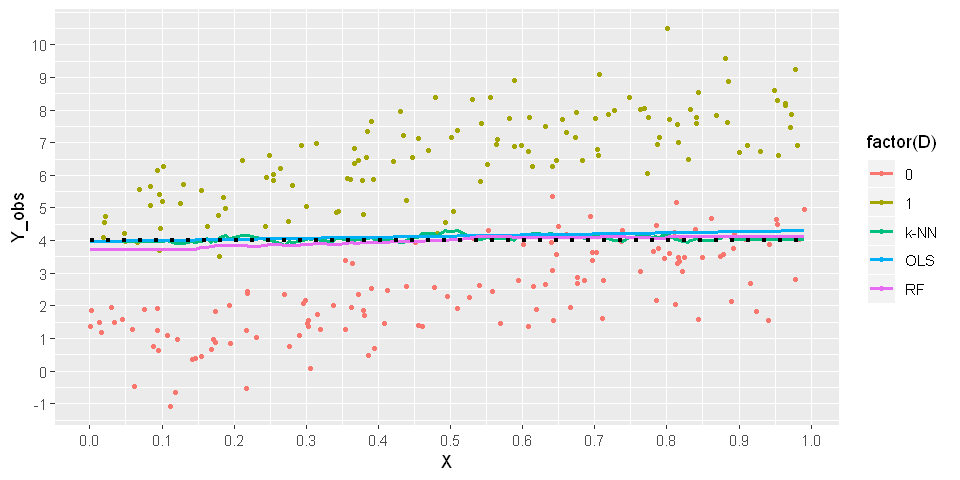

In [34]:
options(repr.plot.width=8, repr.plot.height=4)
set.seed(12)
plot_data(n=500, num_trees=100, kC=50,
                      het_linear = FALSE, random_assignment = TRUE,
                      non_linearY = FALSE, non_linearD = FALSE)


`plot_data()` creates a plot to visually explore the properties of the DGP you have specified. In addition, it visualizes the estimated CATE function, $\widehat{\text{CATE}}$, from the different methods we want to compare. 
<br>
The true $\text{CATE}$ function is the **black dotted** line

**ATE**
<br>
As seen above, $\tau=4$. Since all of the methods except for the Naive estimator can deal with Unconfoundedness, the present setting using completely random treatment assignment can be seen as a warm-up, where we expect all of the methods to work.
<br>
<br>
**CATE**
<br>
To start with, $\tau(x)$ is a constant in this case,  $\tau(x)=\tau=4$. 
<br>
Since both potential outcomes are linear functions of $X$, $\text{OLS}$ works perfectly fine. 
<br>
On the other hand, RF are known to struggle with smooth surfaces (cite A/W or ESL), and would need more observations to recognize the pure linearity. Compared to kNN, however, RF seem to do quite well. This is because kNN is an entirely non-parametric procedure which has a hard time detecting smoothness here. We could improve its performance by increasing $kC$, because averaging over more neighbors necessarily increases smoothness. At the same time, we implicitly restrict the estimated functional form by doing this.

Let's see whether our hypotheses are matched by the simulation results.

In [18]:
set.seed(12)
create_output_table(n = 500, N = 500, B = 500, k = 1, kC = 50, num_trees = 100,
                           het_linear = FALSE, random_assignment = TRUE,
                           non_linearY = FALSE, non_linearD = FALSE,
                           method_ols = "D_only",
                           knn_se5 = TRUE, ols_se5 = TRUE, C_ols_se5 = TRUE,
                           C_knn_se5 = TRUE, boot5 = FALSE,
                           para = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


$ATE
       Description      Naive        OLS        PSW       k_NN         RF
1     avg_estimate     4.0015     4.0015    4.00324     4.0076    4.00472
2     sd_estimates     0.1216     0.1216    0.09206     0.1060    0.09715
3 avg_estimated_se     0.1185     0.1183         NA     0.1039    0.09682

$CATE
  Description        OLS       k_NN         RF
1     avg_mse    0.04139    0.04263    0.05165
2 avg_mean_se    0.08722    0.06839    0.22203

**ATE**
<br>
As expected, the distribution of the estimates of all methods are centered around the true value. 
<br>
In addition, Naive and OLS produce numerically equivalent estimates.
<br>
Furthermore, all estimators exhibit similar standard deviations.
<br>
<br>
**CATE**
<br>
Unsurprisingly, OLS outperforms its competitors. Notably, RF is the close second while kNN trails behind a bit.


## 2.4 Results: Unconfoundedness, Linearity, and Constant Treatment Effects

The only thing to be changed with respect to the previous setting concerns the treatment assignment rule. More specifically, instead of purely random treatment assignment we're using 

$$\begin{equation*}
\zeta(x) = 0.6 x + 0.2,
\end{equation*}$$
<br>
which is an increasig function of $X$. We thus expect to see few treated units relative to untreated ones for small values of $X$ and vice versa.


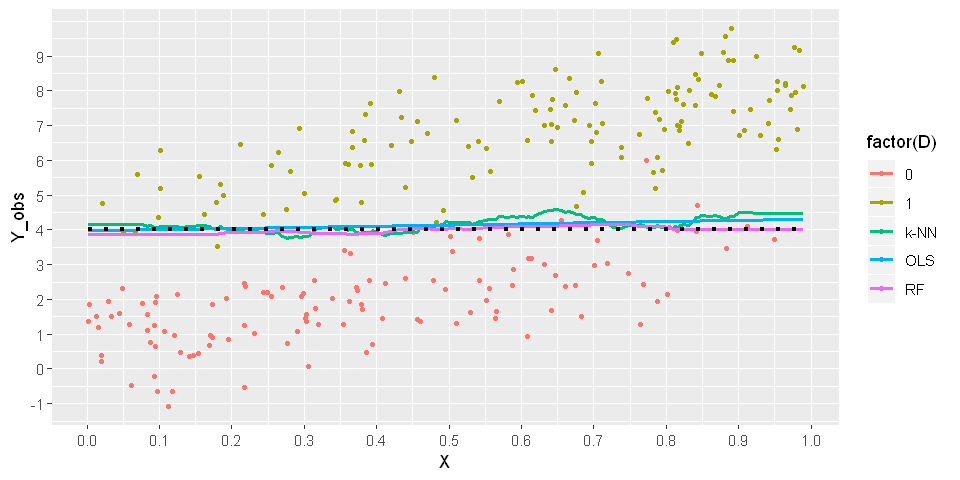

In [35]:
options(repr.plot.width=8, repr.plot.height=4)
set.seed(12)
plot_data(n=500, num_trees=100, kC=50,
                      het_linear = FALSE, random_assignment = FALSE,
                      non_linearY = FALSE, non_linearD = FALSE)


The only difference noticeable through eye-balling is that there are relatively few treated units relative to untreated ones for small values of $X$, and vice versa for values of $X$ close to 1. What do we expect in terms of estimation performance?

Clearly, we not have random assignment but the weaker condition of unconfoundedness is still satisfied: conditional on a realization of $X = x$, the probability of receiving treatment is the same for every unit.
<br>
**ATE**
<br>
As we've seen in the course, the Naive estimator will break down while the PSW estimator will still work. kNN and RF were developed explicitly assuming unconfoundedness and should therefore handle this setup well. OLS will not work if we do not additionally control for $X$, thereby closing the back-door path suggested in the cuasal graph above. 
<br>
<br>
**CATE**
<br>
As mentioned earlier, all of the methods can deal with unconfoundedness. Thus we expect similar results as in the last setup.

In [36]:
create_output_table(n = 500, N = 500, B = 500, k = 1, kC = 50, num_trees = 100,
                           het_linear = FALSE, random_assignment = FALSE,
                           non_linearY = FALSE, non_linearD = FALSE,
                           method_ols = "full",
                           knn_se5 = TRUE, ols_se5 = TRUE, C_ols_se5 = TRUE,
                           C_knn_se5 = TRUE, boot5 = FALSE,
                           para = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


$ATE
       Description      Naive        OLS        PSW       k_NN         RF
1     avg_estimate     4.5982    4.00217    4.00434     4.0037     4.0077
2     sd_estimates     0.1119    0.09403    0.09564     0.1143     0.1037
3 avg_estimated_se     0.1155    0.09532         NA     0.1122     0.1077

$CATE
  Description        OLS       k_NN         RF
1     avg_mse    0.04199    0.07061    0.04852
2 avg_mean_se    0.08666    0.07512    0.21751

**ATE**
<br>
As expected, the Naive estimator breaks down if random treatment assignment is violated.
<br>
As conjectured before, controlling for $X$ in OLS estimation leaves us on the safe side
<br>
Again, all estimators exhibit similar standard deviations. The uncertainty of OLS estimates was reduced by the inclusion of $X$ and the interction of $X$ and $D$.
<br>
<br>
**CATE**
<br>
Same comments as above apply.

**Remark** <br>
One may wonder whether these results are sensitive to the choice of $\zeta(x)$ for treatment assignment. The short answer is: yes they are. As we've seen in the course, the PSW estimator will only work if we produce decent estimates of the propensity score. Since I've decided to use logistic regression to obtain them, they'll be rendered useless if we misspecify $\zeta(x)$ by using logistic regression. Exactly this is the case if you specify `non_linearD = TRUE`, which I'll leave to you to experiment with.

In [19]:
create_output_table_JASA(n = 100, N = 100, d = 10, num_trees = 200, kC = 7,
                       para = FALSE, C_knn_se5 = FALSE )

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Description,OLS,k_NN,RF
<I<chr>>,<I<chr>>,<I<chr>>,<I<chr>>
avg_mse,0.71,0.709,1.12
